## COSC 3337: Data Science I - Group Project
### Team: Naomi Ayub, Elyjaiah Durden, Nirmal John
### Task Category: Classification

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from collections import Counter
from scipy.cluster.hierarchy import linkage, dendrogram

In [29]:
# -------------------------PREPROCESSING OF DATA-------------------------
# Load dataset
df = pd.read_csv('owid_covid_data.csv')

# Basic cleaning
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime type

# Forward-fill total_cases and total_deaths for each location
df[['total_cases', 'total_deaths']] = df.groupby('location')[['total_cases', 'total_deaths']].ffill().copy()

# Fill NA in "new_cases" and "new_deaths" with 0 where total_cases/total_deaths exist
df.loc[df['total_cases'].notna(), 'new_cases'] = df.loc[df['total_cases'].notna(), 'new_cases'].fillna(0)
df.loc[df['total_deaths'].notna(), 'new_deaths'] = df.loc[df['total_deaths'].notna(), 'new_deaths'].fillna(0)

# Drop rows where 'total_cases' or 'total_deaths' is still NaN (if any)
df = df.dropna(subset=['total_cases', 'total_deaths'])

# Create new features safely
df['daily_case_change_rate'] = df['new_cases'] / df['total_cases'].replace(0, pd.NA)
df['daily_case_change_rate'] = pd.to_numeric(df['daily_case_change_rate'], errors='coerce')

df['daily_death_change_rate'] = df['new_deaths'] / df['total_deaths'].replace(0, pd.NA)
df['daily_death_change_rate'] = pd.to_numeric(df['daily_death_change_rate'], errors='coerce')

df['hospitalization_rate'] = df['hosp_patients'] / df['population']
df['icu_rate'] = df['icu_patients'] / df['population']

df['case_fatality_rate'] = df['total_deaths'] / df['total_cases']
df['case_fatality_rate'] = pd.to_numeric(df['case_fatality_rate'], errors='coerce')

# Handle infinite values (if any due to division by zero)
df = df.replace([float('inf'), -float('inf')], pd.NA)

# Fill NaNs created in new features with 0 or leave as NaN depending on context
columns_to_fill = ['daily_case_change_rate', 'daily_death_change_rate', 'hospitalization_rate', 'icu_rate', 'case_fatality_rate']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# Save preprocessed data
df.to_csv('preprocessed_covid_data.csv', index=False)

# Final check
print("Shape of preprocessed data:", df.shape)
print("\nData Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing values per column:")
print(df.isna().sum())

Shape of preprocessed data: (412909, 72)

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 412909 entries, 0 to 429434
Data columns (total 72 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    412909 non-null  object        
 1   continent                                   392784 non-null  object        
 2   location                                    412909 non-null  object        
 3   date                                        412909 non-null  datetime64[ns]
 4   total_cases                                 412909 non-null  float64       
 5   new_cases                                   412909 non-null  float64       
 6   new_cases_smoothed                          408929 non-null  float64       
 7   total_deaths                                412909 non-null  float64       
 8   new_deaths                

### Risk Categorization with Classfication Models

##### SECTION 1: Defining the Problem

In [30]:
# Load preprocessed dataset
df = pd.read_csv('preprocessed_covid_data.csv')

# Define target variable: hospitalization_need using 'icu_rate'
icu_nonzero = df[df['icu_rate'] > 0]['icu_rate']

# Safe binning based on number of unique values
num_unique = len(icu_nonzero.unique())

if num_unique >= 3:
    # 3 classes
    q = 3
    labels = ['Low', 'Medium', 'High']
elif num_unique == 2:
    # 2 classes
    q = 2
    labels = ['Low', 'High']
elif num_unique == 1:
    # Only 1 unique value — bin into single class manually
    df['hospitalization_need'] = 'Low'
    q = None  # skip qcut
else:
    raise ValueError("Not enough nonzero ICU rate values to create categories.")

if q is not None:
    try:
        df['hospitalization_need'] = pd.qcut(
            df['icu_rate'],
            q=q,
            labels=labels,
            duplicates='drop'
        )
    except ValueError:
        # Fallback: if qcut still fails, use manual binning
        bins = [-0.01, df['icu_rate'].median(), df['icu_rate'].max()]
        df['hospitalization_need'] = pd.cut(
            df['icu_rate'],
            bins=bins,
            labels=['Low', 'High'],
            include_lowest=True
        )

# Drop rows with missing hospitalization_need
df = df.dropna(subset=['hospitalization_need'])

# Features for classification
features = [
    'total_cases', 'new_cases', 'new_deaths', 
    'case_fatality_rate', 'life_expectancy', 
    'hospital_beds_per_thousand', 'population_density', 'gdp_per_capita'
]

X = df[features]
y = df['hospitalization_need']

# Handle missing values
X = X.fillna(X.median())

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Double check at least 2 classes exist
if len(np.unique(y_encoded)) < 2:
    raise ValueError("Not enough classes to perform classification. Need at least 2 different hospitalization_need levels.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

##### SECTION 2: Building the Logistic Regression & Random Forest Classifier Models

In [31]:
# Baseline Model: Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

# Advanced Model: Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

##### SECTION 3: Evaluation of the Logistic Regression & Random Forest Classifier Models

--- Logistic Regression ---
Accuracy: 0.91770603763532
Precision: 0.45885301881766
Recall: 0.5
F1 Score: 0.4785436451808446

--- Random Forest ---
Accuracy: 0.9960766268678405
Precision: 0.9870759418472355
Recall: 0.9869454500977295
F1 Score: 0.9870106853147245



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


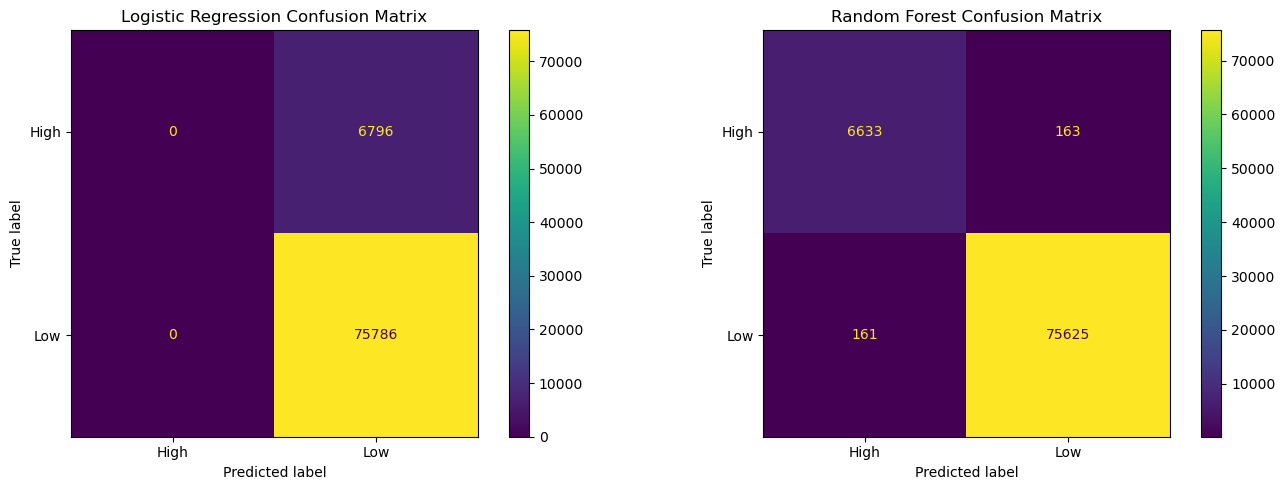

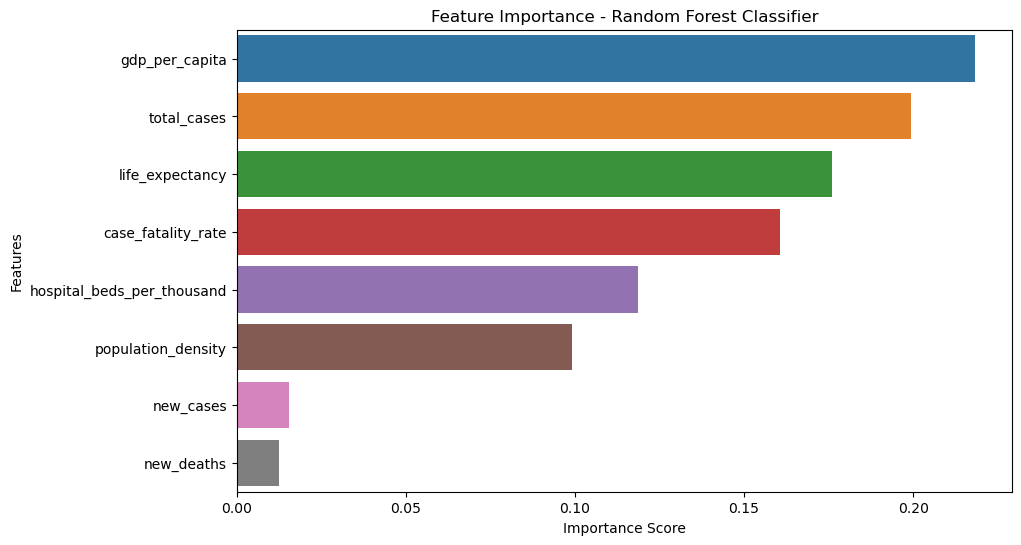

In [32]:
models = {
    'Logistic Regression': y_pred_logreg,
    'Random Forest': y_pred_rf
}
for name, preds in models.items():
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))
    print("F1 Score:", f1_score(y_test, preds, average='macro'))
    print()

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, display_labels=le.classes_, ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=le.classes_, ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature Importance for Random Forest
importances = rf_clf.feature_importances_
feat_importances = pd.Series(importances, index=features)
feat_importances = feat_importances.sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title('Feature Importance - Random Forest Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

#### SECTION 4: Implementation of K-Fold Cross-Validation to Validate Model Stability

In [33]:
# Cross-validation
cv_scores_logreg = cross_validate(log_reg, X, y_encoded, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
cv_scores_rf = cross_validate(rf_clf, X, y_encoded, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
print("Logistic Regression CV Scores:", pd.DataFrame(cv_scores_logreg).mean())
print("Random Forest CV Scores:", pd.DataFrame(cv_scores_rf).mean())

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression CV Scores: fit_time                1.558177
score_time              0.070582
test_accuracy           0.901564
test_precision_macro    0.508148
test_recall_macro       0.491448
test_f1_macro           0.474488
dtype: float64
Random Forest CV Scores: fit_time                18.617829
score_time               0.692076
test_accuracy            0.916522
test_precision_macro     0.710537
test_recall_macro        0.662479
test_f1_macro            0.681067
dtype: float64
